<font size="6"><center>**EDA and Survival Prediction of Titanic Dataset**</center></font>

# Table of Contents
* [Introduction](#Introduction)
* [Data Preparation and Cleaning](#Data-Preparation-and-Cleaning)
  * [Importing the Data](#Importing-the-Data)
  * [Duplicate and Missing Values](#Duplicate-and-Missing-Values)
  * [Observations and Features](#Observations-and-Features)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
  * [Distribution of Features](#Distribution-of-Features)
  * [Survival Rates in Different Categories](#Survival-Rates-in-Different-Categories)
* [Survival Prediction Using Random Forest](#Survival-Prediction-Using-Random-Forest)
* [Summary](#Summary)
 


# Introduction

The Titanic dataset from [Kaggle](https://www.kaggle.com/competitions/titanic) is a classic binary classification problem: **predict whether a passenger survived** based on features like age, sex, and others. To build an effective model, we begin with **Exploratory Data Analysis (EDA)** to uncover patterns and relationships in the data.

During EDA, we examine survival rates across different groups—such as by `Sex`, `Pclass`, and `Age`—and handle missing data (especially in `Age` and `Embarked`). Visualizations and summaries help guide feature selection and engineering, like combining `SibSp` and `Parch` into a `FamilySize` feature.

For prediction, we use a **Random Forest classifier**—a powerful ensemble method that handles both numerical and categorical features well and captures non-linear relationships. After encoding categorical variables and imputing missing values, we train and tune the model, then evaluate its performance using cross-validation.

This combination of EDA and Random Forest modeling provides a strong baseline for predicting survival on the Titanic.

# Data Preparation and Cleaning
## Importing the Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Modelling
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample 

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# Setting plotting style
plt.style.use("fast")

In [2]:
# Importing the data
df = pd.read_csv("train.csv", index_col=0)
print(df.shape)
df.head()

(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Duplicate and Missing Values

From the code below we can see that the data does not have any duplicated values. There are some missing values in the features `Age`, `Cabin`, and `Embarked`.

In [3]:
# Checking for duplicate samples
print("Number of identical lines in the dataset:", df.duplicated().sum())

Number of identical lines in the dataset: 0


In [4]:
# Checking for missing values
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [5]:
# Separate rows with known and missing Age
known_age = df[df["Age"].notnull()]
unknown_age = df[df["Age"].isnull()]

# Choose predictors (excluding Age and other high-missing or ID-like columns)
features = ["Pclass", "Sex", "SibSp", "Parch", "Fare", "Embarked"]

# Encode categorical variables
df_encoded = df.copy()
for col in ["Sex", "Embarked"]:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Split encoded data again
known_age = df_encoded[df_encoded["Age"].notnull()]
unknown_age = df_encoded[df_encoded["Age"].isnull()]

# Define X and y
X_train = known_age[features]
y_train = known_age["Age"]
X_pred = unknown_age[features]

# Train Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=100, random_state=42)
rfr.fit(X_train, y_train)

# Predict missing ages
predicted_ages = rfr.predict(X_pred)

# Fill in the missing values
df.loc[df["Age"].isnull(), "Age"] = predicted_ages

df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Observations and Features


| Variable | Definition | Key |
| --- | --- | --- |
|Survival | Survival | 0 = No, 1 = Yes |
|Pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex |
|Age | Age in years |
|SibSp | # of siblings / spouses aboard the Titanic |
|Parch | # of parents / children aboard the Titanic |
|ticket | Ticket number| 	
|fare | Passenger fare 	|
|cabin | Cabin number 	|
|embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton|

# Exploratory Data Analyses
## Distribution of Features

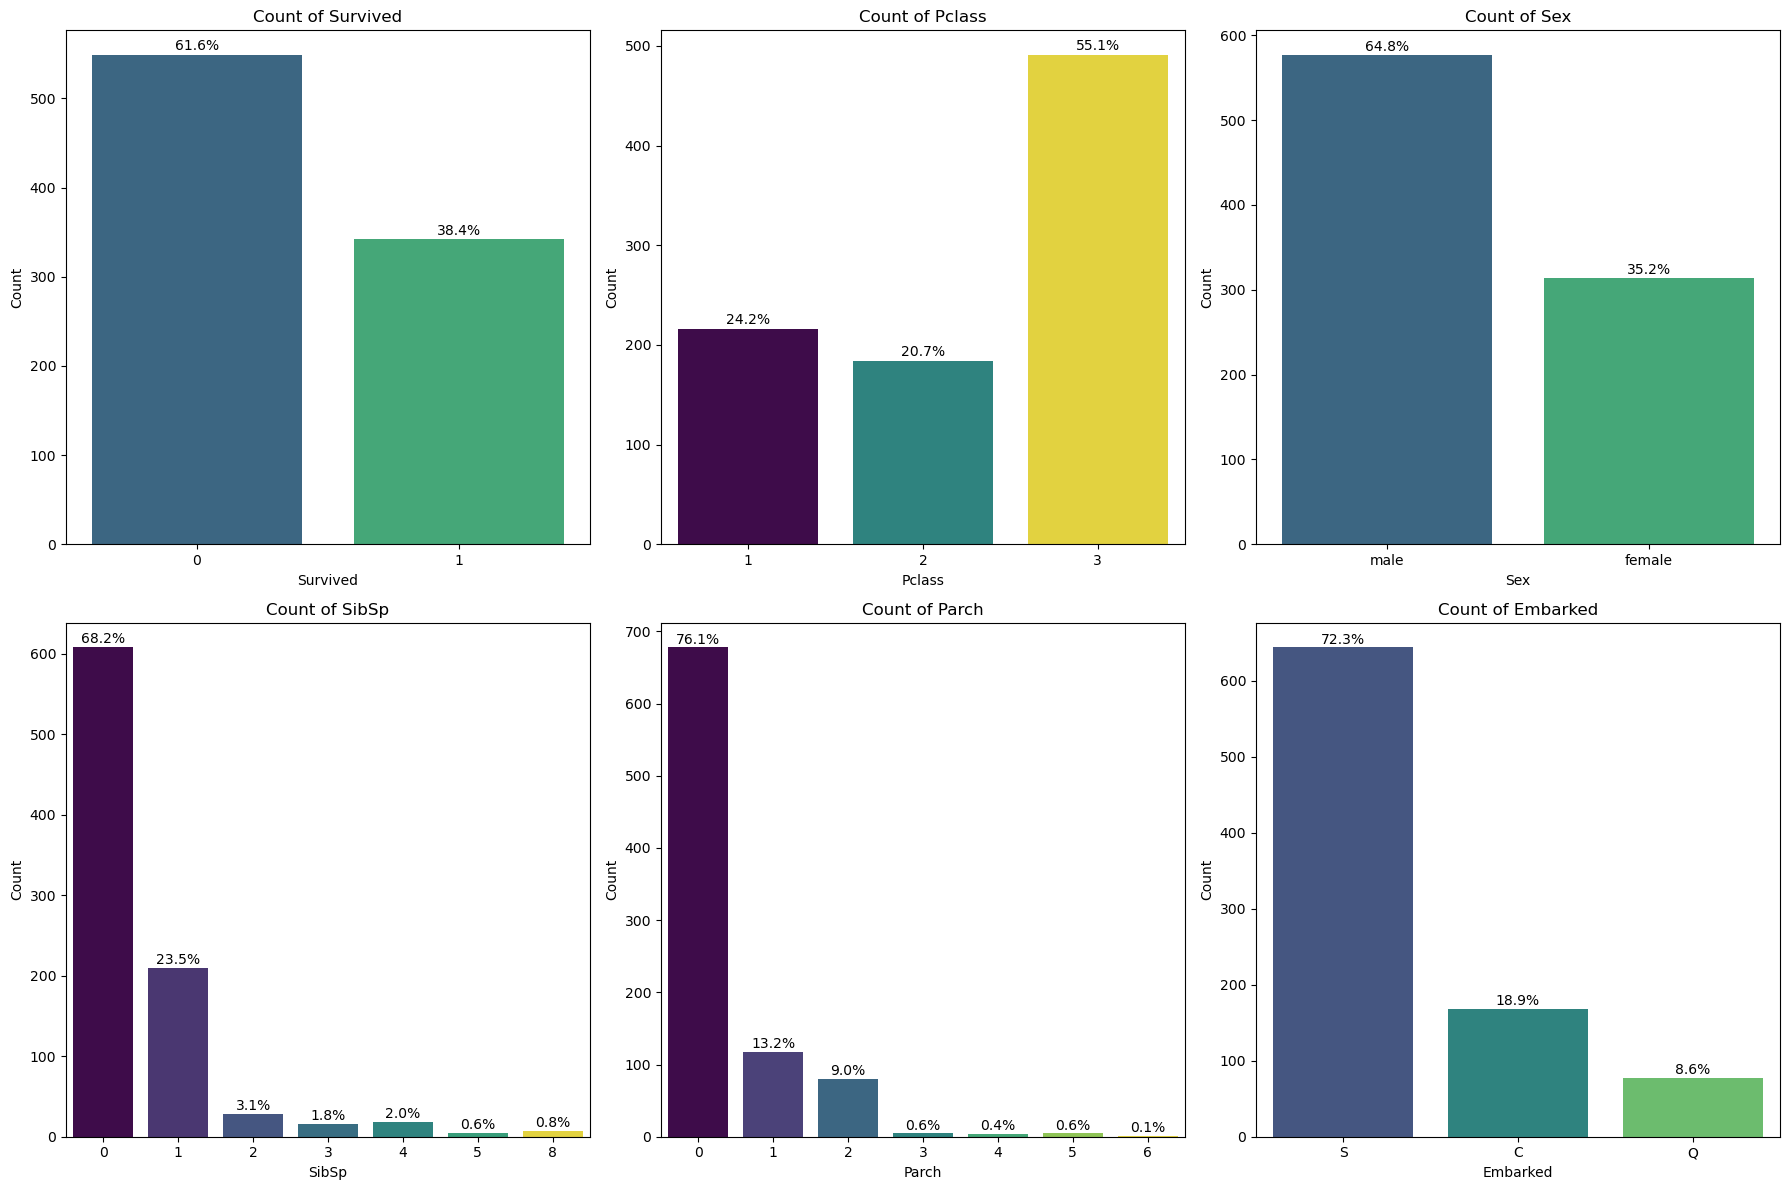

In [6]:
# List of categorical features
cat_features = ["Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked"]

# Plotting categorical features
plt.figure(figsize=(18, 12))
for i, col in enumerate(cat_features, 1):
    plt.subplot(2, 3, i)
    ax = sns.countplot(data=df, x=col, hue=col, palette="viridis", legend=False)

    total = len(df)
    for p in ax.patches:
        count = p.get_height()
        percentage = 100 * count / total
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.text(x, y + 5, f"{percentage:.1f}%", ha="center", fontsize=10)

    plt.title(f"Count of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

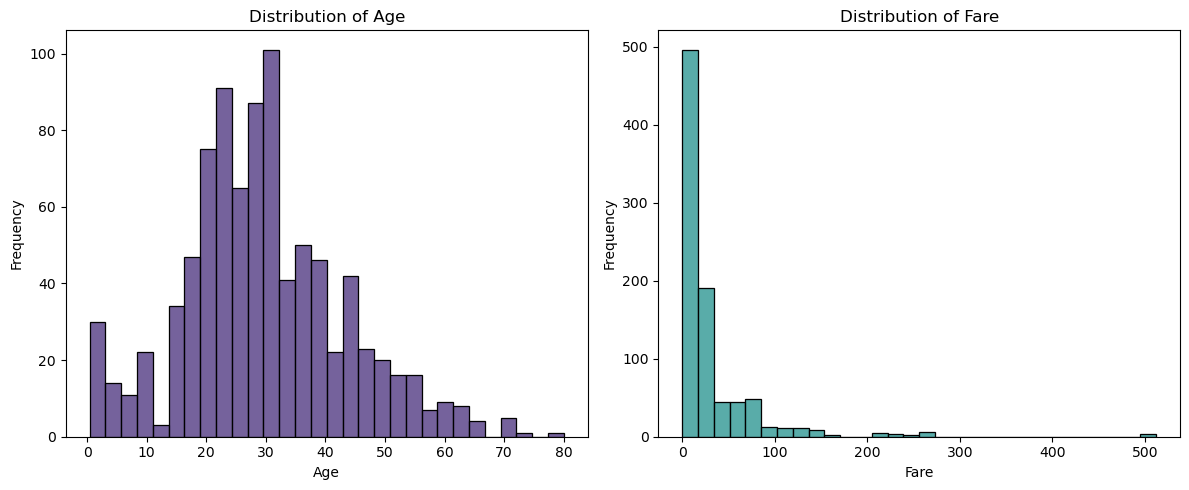

In [7]:
# Plotting numerical features
plt.figure(figsize=(12, 5))

# Histogram for Age
plt.subplot(1, 2, 1)
sns.histplot(data=df, x="Age", bins=30, color="#472d7b")
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")

# Histogram for Fare
plt.subplot(1, 2, 2)
sns.histplot(data=df, x="Fare", bins=30, color="#21918c")
plt.title("Distribution of Fare")
plt.xlabel("Fare")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## Survival Rates in Different Categories

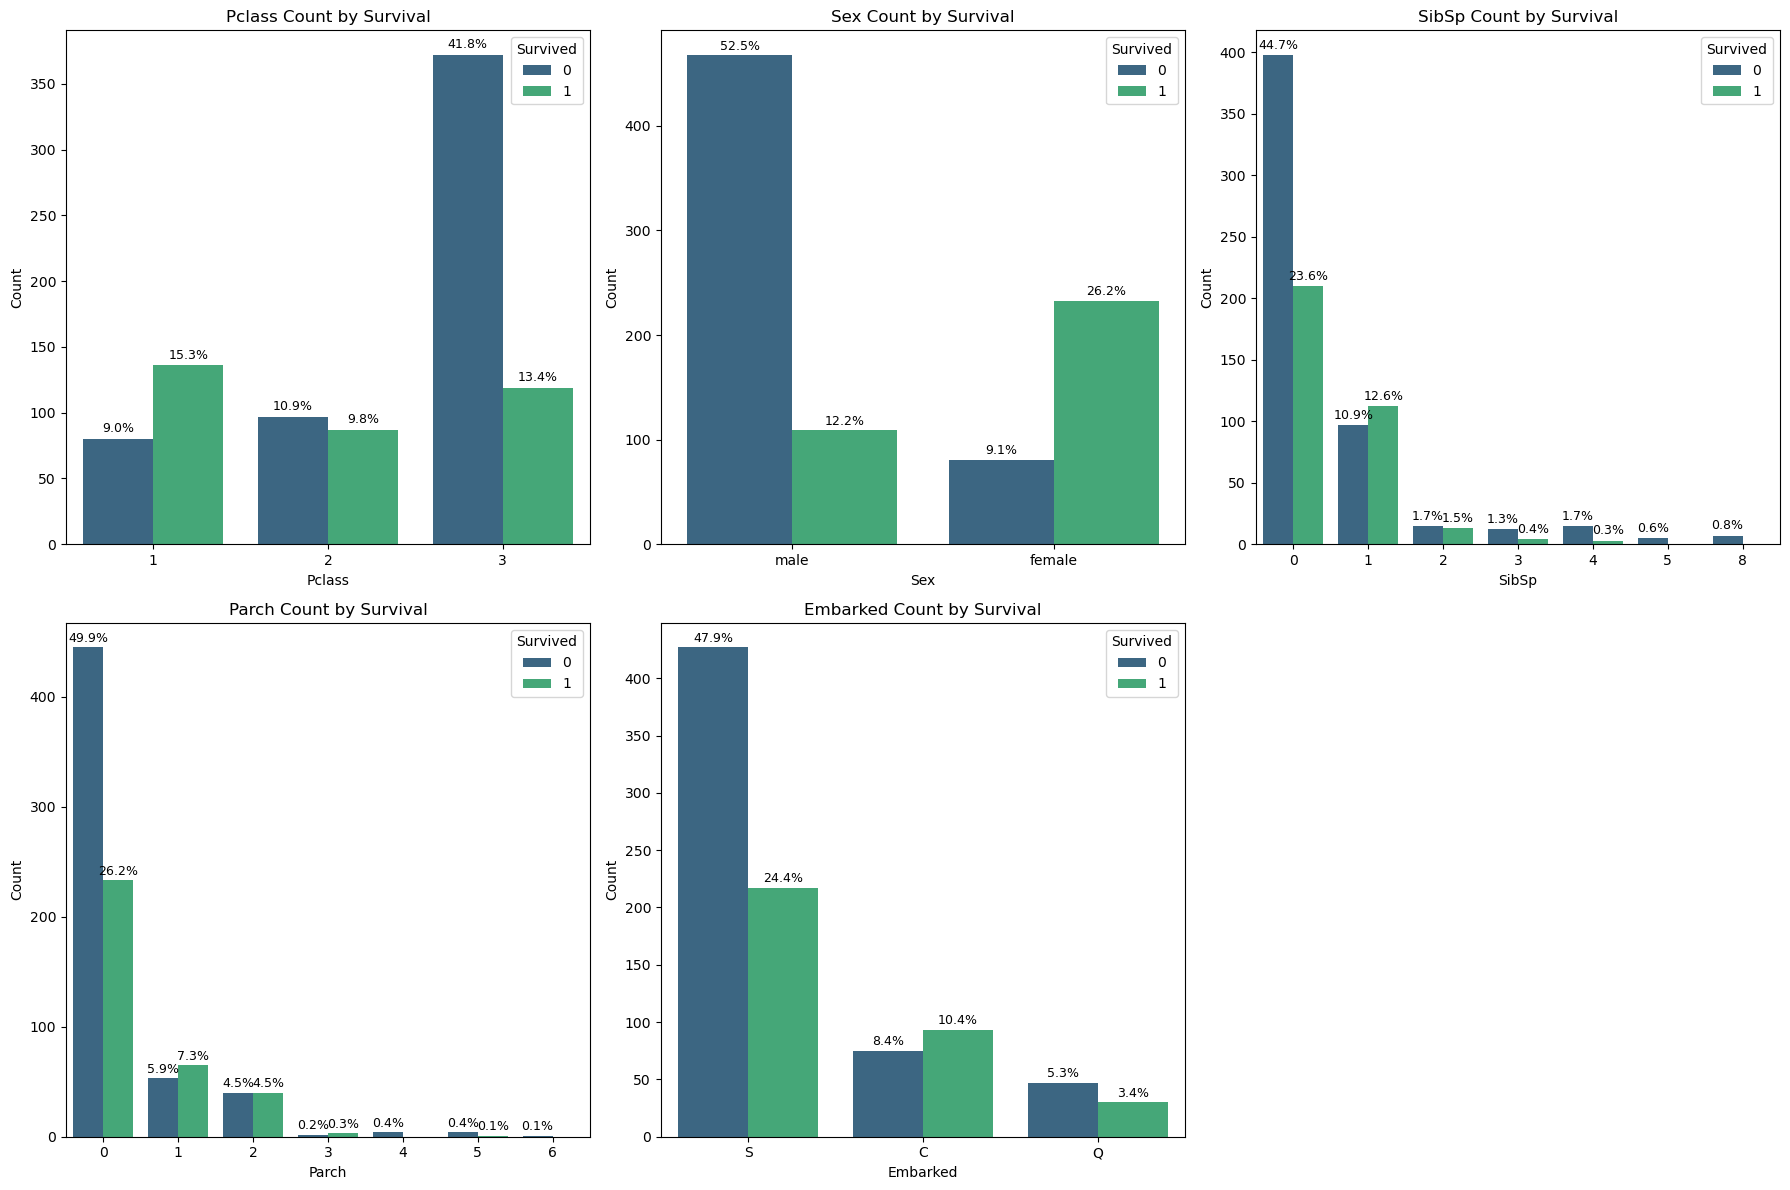

In [8]:
plt.figure(figsize=(18, 12))

# List of categorical features
cat_features = ["Pclass", "Sex", "SibSp", "Parch", "Embarked"]

# Plot countplots with percentages
for i, col in enumerate(cat_features, 1):
    plt.subplot(2, 3, i)
    ax = sns.countplot(data=df, x=col, hue="Survived", palette="viridis")

    # Calculate total counts for column (grouped by x + hue)
    total = len(df)
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height == 0:
                continue
            percentage = 100 * height / total
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 5,
                f"{percentage:.1f}%",
                ha="center",
                fontsize=9
            )

    plt.title(f"{col} Count by Survival")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.legend(title="Survived", loc="upper right")

plt.tight_layout()
plt.show()

# Survival Prediction Using Random Forest

In this section, we build a machine learning model to predict passenger survival using a Random Forest Classifier. This ensemble method combines multiple decision trees to improve prediction accuracy and reduce overfitting. After preprocessing the data—handling missing values, encoding categorical variables, and selecting relevant features—we train and evaluate the model on the Titanic dataset. The goal is to assess how well the model can generalize to unseen data and identify key factors influencing survival.


In [9]:
# Drop columns not useful for prediction
df = df.drop(columns=["Name", "Ticket", "Cabin"])

# Fill missing values
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Encode categorical variables
df = pd.get_dummies(df, columns=["Sex", "Embarked"], drop_first=True)

# Features and target
X = df.drop("Survived", axis=1)
y = df["Survived"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8324


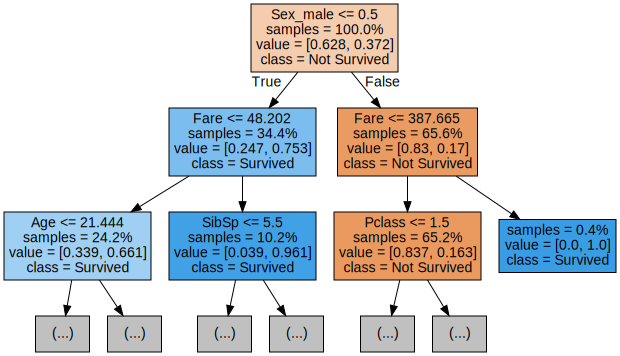

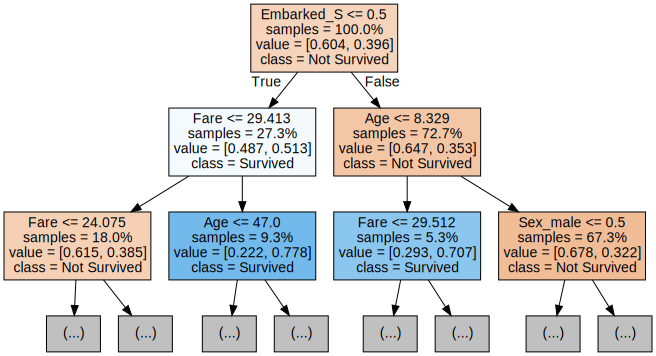

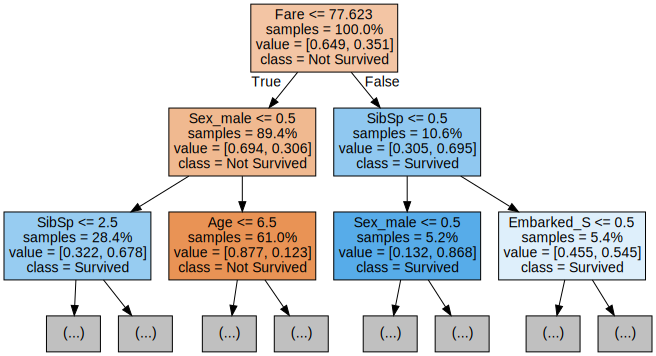

In [10]:
# Export and display the first 3 trees in the forest
for i in range(3):
    tree = model.estimators_[i]
    dot_data = export_graphviz(
        tree,
        feature_names=X_train.columns,
        filled=True,
        max_depth=2,
        impurity=False,
        proportion=True,
        class_names=["Not Survived", "Survived"]
    )
    graph = graphviz.Source(dot_data)
    display(graph)

# Summary

We trained a **Random Forest Classifier** to predict passenger survival on the Titanic dataset. Key features used include:

- `Pclass`
- `Sex`
- `Age`
- `Fare`
- `SibSp`
- `Parch`
- `Embarked`

Categorical variables were encoded using one-hot encoding, and missing values were filled (random forest for `Age`, mode for `Embarked`).

The dataset was split into training and test sets (80/20 split).  
The model achieved an **accuracy of 83.24%** on the test set.

This suggests the model performs well in identifying survival outcomes. Further improvements could involve hyperparameter tuning, feature engineering (e.g., extracting titles from names), or trying other ensemble methods.